In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode (connected = True)

# Importing The Data

In [2]:
data=pd.read_csv('C:/Users/Yusuf/Desktop/Spotify- Song Prediction and Recommendation System/genres_v2.csv')

# Having First Look At The Data

The full list of genres included in the CSV are Trap, Techno, Techhouse, Trance, Psytrance, Dark Trap, DnB (drums and bass), Hardstyle, Underground Rap, Trap Metal, Emo, Rap, RnB, Pop and Hiphop.

In [3]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


# Let's look closer at data with pair plot :)

In [4]:
cols=list(data.columns[11:])
del cols[7]

In [5]:
df=copy.deepcopy(data)
df.drop(columns=cols,inplace=True)

In [6]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

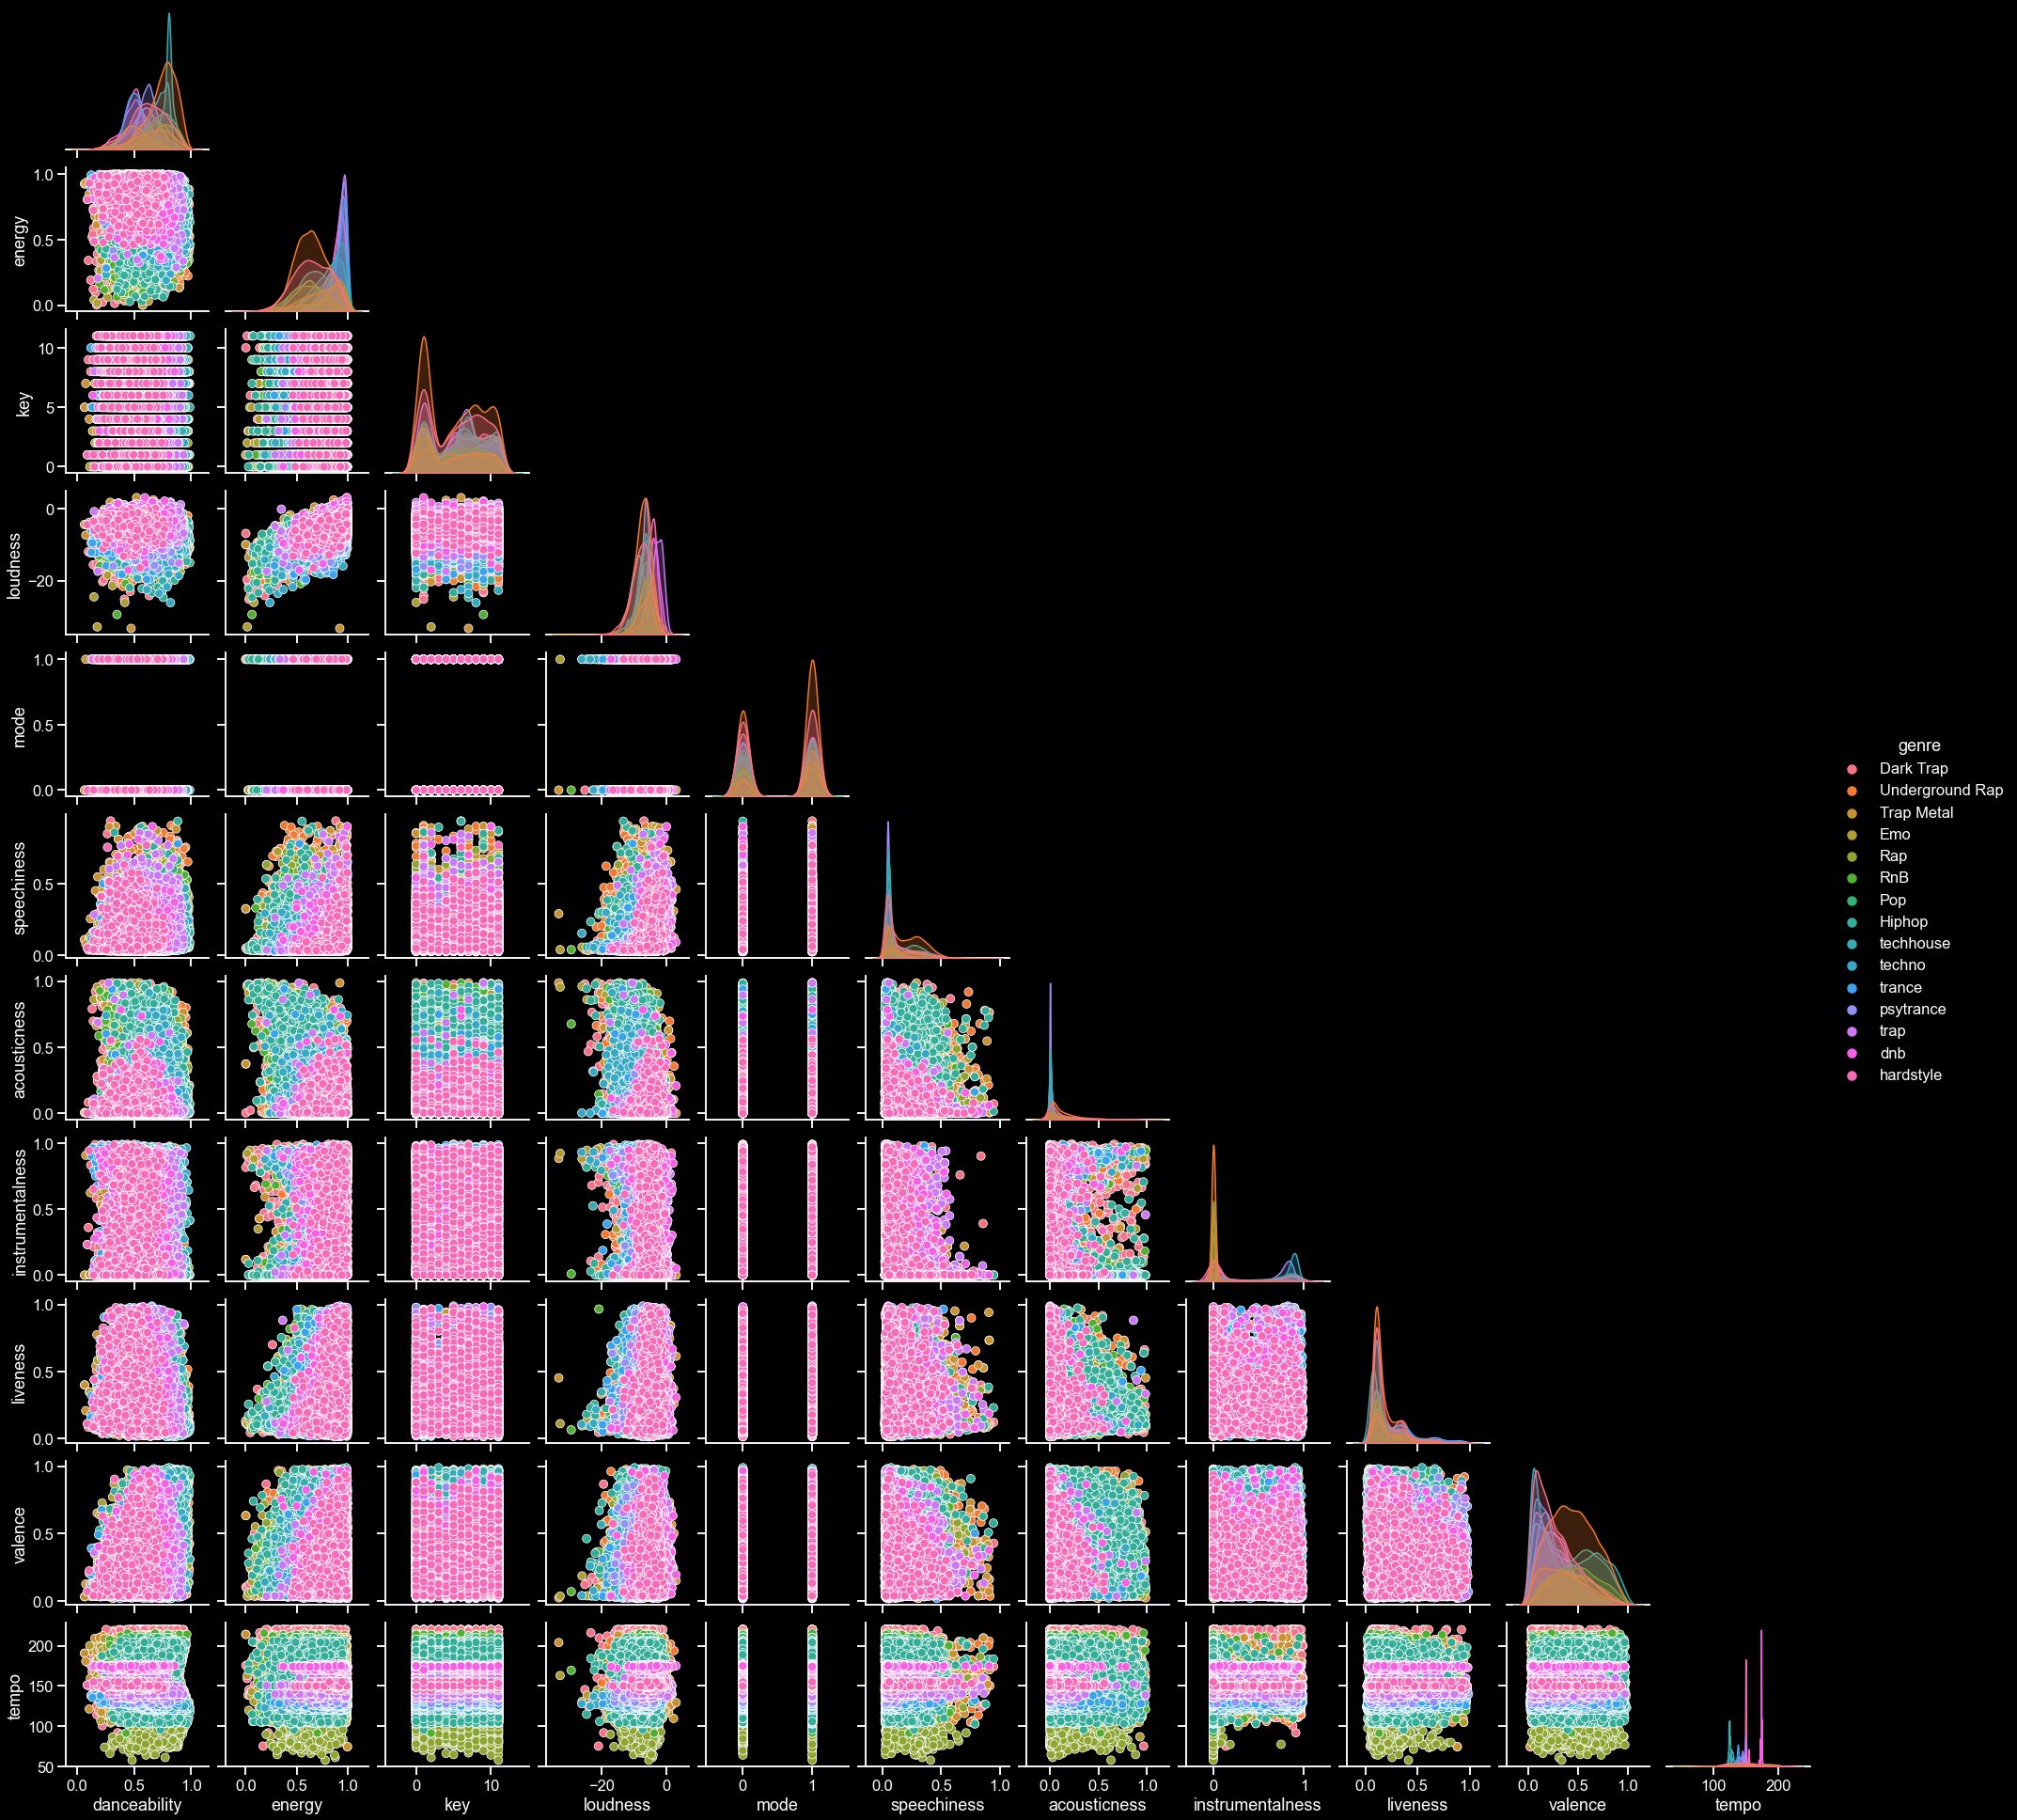

In [7]:
sns.pairplot(df,corner=True,hue='genre')

# Let's have a look at the average time of a song

In [8]:
px.box(data_frame=data,y='duration_ms',color='genre')

Well we can clearly see that most of the genres have their own time ranges pystrance is mostly longer and we can see that trap music is of lower timespan

# HeatMap of the data

In [9]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
x=list(data.corr().columns)
y=list(data.corr().index)
values=np.array(data.corr().values)
fig = go.Figure(data=go.Heatmap(
    z=values,
    x=x,
    y=y,
                   
    
                   hoverongaps = False))
fig.show()

# Let's Make A Recommendation System....

Over here we are gonna different methods to find the closest songs to the one that you have liked :)

# Let's remove all the rows with no song name

In [11]:
data=data.dropna(subset=['song_name'])

# Need to Preprocess the Data

Question arises why do we need to standardize the data ??

Answer : You see that the data has columns like duration ms whose distance difference can be high causing lot of change in the answer we want every field to contribute the same to the distance (euclidean) hence we have to standardize the data .

In [12]:
# Creating a new dataframe with required features
df=data[data.columns[:11]]
df['genre']=data['genre']
df['time_signature']=data['time_signature']
df['duration_ms']=data['duration_ms']
df['song_name']=data['song_name']

In [13]:
x=df[df.drop(columns=['song_name','genre']).columns].values
scaler = StandardScaler().fit(x)
X_scaled = scaler.transform(x)
df[df.drop(columns=['song_name','genre']).columns]=X_scaled

# Recommendation System Using Euclidean Distance

In [14]:
# This is a function to find the closest song name from the list
def find_word(word,words):
    t=[]
    count=0
    if word[-1]==' ':
        word=word[:-1]
    for i in words:
        if word.lower() in i.lower():
            t.append([len(word)/len(i),count])
        else:
            t.append([0,count])
        count+=1
    t.sort(reverse=True)
    return words[t[0][1]]

In [15]:
# Making a weight matrix using euclidean distance
def make_matrix(data,song,number):
    df=pd.DataFrame()
    data.drop_duplicates(inplace=True)
    songs=data['song_name'].values
#    best = difflib.get_close_matches(song,songs,1)[0]
    best=find_word(song,songs)
    print('The song closest to your search is :',best)
    genre=data[data['song_name']==best]['genre'].values[0]
    df=data[data['genre']==genre]
    x=df[df['song_name']==best].drop(columns=['genre','song_name']).values
    if len(x)>1:
        x=x[1]
    song_names=df['song_name'].values
    df.drop(columns=['genre','song_name'],inplace=True)
    df=df.fillna(df.mean())
    p=[]
    count=0
    for i in df.values:
        p.append([distance.euclidean(x,i),count])
        count+=1
    p.sort()
    for i in range(1,number+1):
        print(song_names[p[i][1]])

In [17]:
a=input('Please enter The name of the song :')
b=int(input('Please enter the number of recommendations you want: '))
make_matrix(df,a,b)

Please enter The name of the song :paradise
Please enter the number of recommendations you want: 5
The song closest to your search is : Paradise
Tron Cat
Rise Up
Oh Shit!!!
Regular!
Remember This


# Recommendation System Using Cosine Similarity Distance

In [18]:
def make_matrix_cosine(data,song,number):
    df=pd.DataFrame()
    data.drop_duplicates(inplace=True)
    songs=data['song_name'].values
#    best = difflib.get_close_matches(song,songs,1)[0]
    best=find_word(song,songs)
    print('The song closest to your search is :',best)
    genre=data[data['song_name']==best]['genre'].values[0]
    df=data[data['genre']==genre]
    x=df[df['song_name']==best].drop(columns=['genre','song_name']).values
    if len(x)>1:
        x=x[1]
    song_names=df['song_name'].values
    df.drop(columns=['genre','song_name'],inplace=True)
    df=df.fillna(df.mean())
    p=[]
    count=0
    for i in df.values:
        p.append([distance.cosine(x,i),count])
        count+=1
    p.sort()
    for i in range(1,number+1):
        print(song_names[p[i][1]])

In [20]:
c=input('Please enter The name of the song :')
d=int(input('Please enter the number of recommendations you want: '))
make_matrix_cosine(df,c,d)

Please enter The name of the song :imagine dragons-believer
Please enter the number of recommendations you want: 6
The song closest to your search is : Can't Hold On
Ruffneck
Nightcrawler (feat. Method Man)
20 Joints
Outlawz
Bang Bang
Bang Bang


# Making a recommendation System using Correlation Distance

In [21]:
def make_matrix_correlation(data,song,number):
    df=pd.DataFrame()
    data.drop_duplicates(inplace=True)
    songs=data['song_name'].values
#    best = difflib.get_close_matches(song,songs,1)[0]
    best=find_word(song,songs)
    print('The song closest to your search is :',best)
    genre=data[data['song_name']==best]['genre'].values[0]
    df=data[data['genre']==genre]
    x=df[df['song_name']==best].drop(columns=['genre','song_name']).values
    if len(x)>1:
        x=x[1]
    song_names=df['song_name'].values
    df.drop(columns=['genre','song_name'],inplace=True)
    df=df.fillna(df.mean())
    p=[]
    count=0
    for i in df.values:
        p.append([distance.correlation(x,i),count])
        count+=1
    p.sort()
    for i in range(1,number+1):
        print(song_names[p[i][1]])

In [23]:
e=input('Please enter The name of the song :')
f=int(input('Please enter the number of recommendations you want: '))
make_matrix_correlation(df,e,f)

Please enter The name of the song :roar
Please enter the number of recommendations you want: 6
The song closest to your search is : Roar
That's My Girl
Alejandro
Ain't My Fault
Lean On (feat. MØ & DJ Snake)
Me And My Broken Heart
Cold Water (feat. Justin Bieber & MØ)


Hope you try it first :)
Hope you liked the recommended songs :)
Just a simple method to make a recommendation system :)
Thank you :)